In [11]:
import os
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

In [12]:
%matplotlib notebook

In [13]:
working_dir = '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/'
os.listdir(working_dir)

['example_roi_Artifacts.pdf',
 'example_roi_Adjacent.pdf',
 'umap_d35_vs_d60.pdf',
 'feature_correlation_graph.html',
 'volcano_d35_d60.pdf',
 'feature_correlation_graph_0_75_labels.html',
 'average_profile_TBR1-LowDN.pdf',
 'example_slices.pdf',
 'average_profile_TBR1-HighDN.pdf',
 'example_roi_Surface.pdf',
 'clustermap_d35_d60_hits.pdf',
 'Lancaster_d60',
 'relative_stderr_plot.pdf',
 'example_roi_DN.pdf',
 'cyto_profiles_combined.npy',
 'feature_correlation_graph_0_8_nolabels.html',
 'feature_correlation_graph_0_6.html',
 'average_profile_DN.pdf',
 'feature_correlation_graph_0_7.html',
 'feature_correlation_graph_0_8.html',
 'analysis.csv',
 'pseudoslice_2d_vs_3d_dist.pdf',
 'cyto_clusters_umap.pdf',
 'average_profile_Artifacts.pdf',
 'feature_correlation_graph_0_75_nolabels.html',
 'model_d35_d60.umap',
 'average_profile_Surface.pdf',
 'pseudoslices_2d_vs_3d_sigma.pdf',
 'clustermap.pdf',
 'Lancaster_d35',
 'feature_edge_ranks.xlsx',
 'example_roi_TBR1-HighDN.pdf',
 'cyto_profiles

In [14]:
print(len(os.listdir(os.path.join(working_dir, 'Lancaster_d35'))))
print(len(os.listdir(os.path.join(working_dir, 'Lancaster_d60'))))

12
8


In [6]:
profiles = np.load(os.path.join(working_dir, 'cyto_profiles_combined.npy'))
profiles.shape

(100000, 3, 6)

In [7]:
features = profiles.reshape((len(profiles), -1))

Optional scaling and preprocessing (Skip)

In [83]:
means = profiles.mean(axis=0).mean(axis=-1) * np.ones((profiles.shape[-1], 3))
scaled_profiles = profiles / means.T
scaled_profiles.shape

(55000, 3, 6)

In [60]:
from sklearn.preprocessing import scale

In [64]:
scaled_features = scale(features)

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Flattened profiles seem best here...

In [8]:
np.random.seed(7)
model = UMAP(metric='euclidean', n_neighbors=15).fit(features)
x_umap = model.transform(features)
x_umap.shape

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/umap/rp_tree.py (457)

File "../../.conda/envs/scout/lib/python3.6/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make

(100000, 2)

<IPython.core.display.Javascript object>


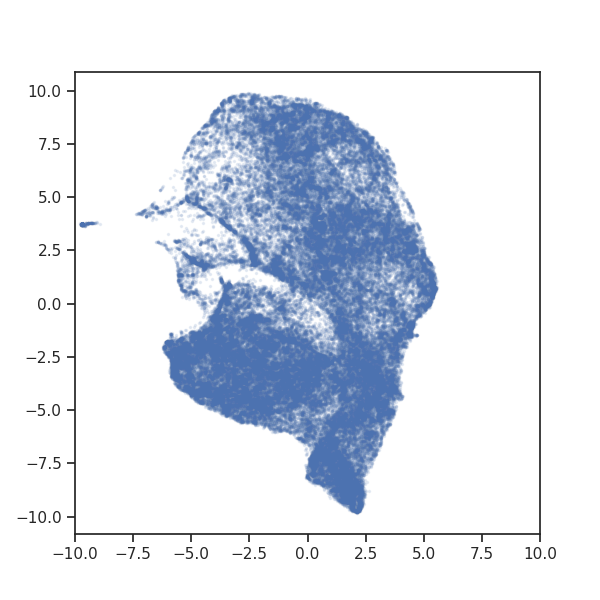

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(x_umap[:, 0], x_umap[:, 1], '.', alpha=0.1, markersize=3)
plt.xlim([-10, 10])
plt.show()

Filter bad profiles

In [8]:
good_idx = np.where(x_umap[:, 0] < 10)
x_umap = x_umap[good_idx]
features = features[good_idx]

In [9]:
profiles = profiles[good_idx]

<IPython.core.display.Javascript object>


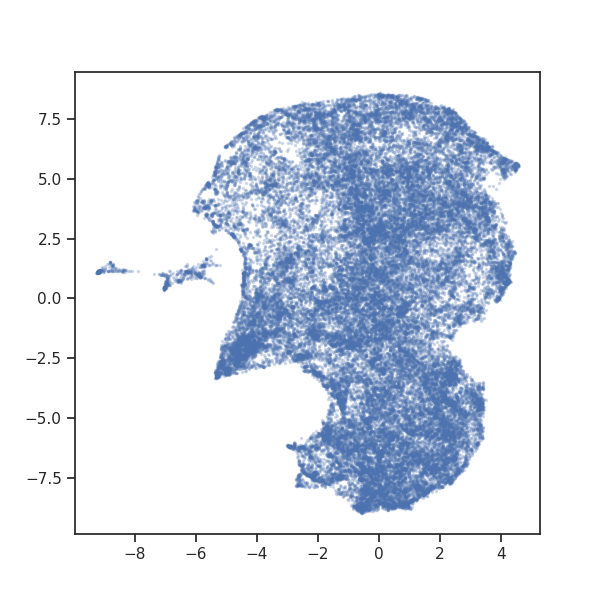

In [14]:
plt.figure(figsize=(6, 6))
plt.plot(x_umap[:, 0], x_umap[:, 1], '.', alpha=0.2, markersize=3)
plt.show()

Agglomerative Clustering

In [9]:
from sklearn.cluster import AgglomerativeClustering

In [10]:
clustering = AgglomerativeClustering(n_clusters=6, linkage='average').fit(x_umap) # 8, 9, 10
labels = clustering.labels_

class_labels = np.unique(labels)
class_labels

array([0, 1, 2, 3, 4, 5])

<IPython.core.display.Javascript object>


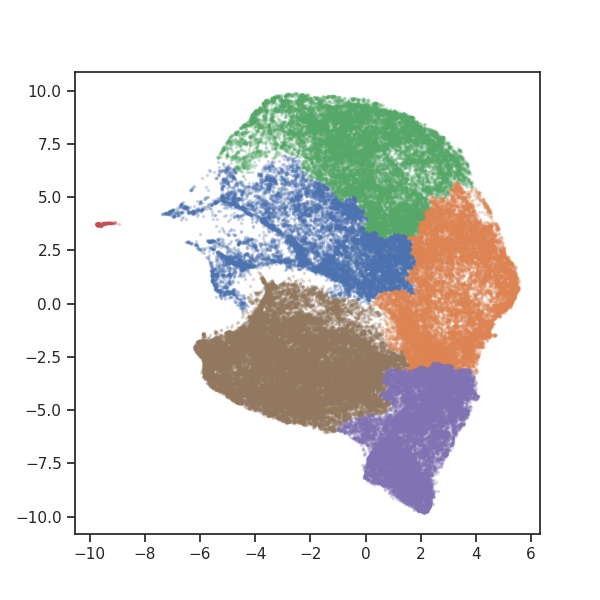

In [11]:
plt.figure(figsize=(6, 6))
for i in range(0, class_labels.max() + 1):
    idx = np.where(labels == i)[0]
    plt.plot(x_umap[idx, 0], x_umap[idx, 1], '.', alpha=0.2, markersize=3)
# plt.xlim([-8, 8])
plt.show()

Show organoid labels

In [13]:
sample_labels = np.load(os.path.join(working_dir, 'cyto_profiles_combined_samples.npy')).astype(np.int)
np.unique(sample_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [ ]:
sample_labels = sample_labels[good_idx]

In [27]:
cluster_names = ['TBR1-LowDN',
                 'TBR1-HighDN',
                 'Surface',
                 'Artifacts',
                 'DN',
                 'Adjacent']

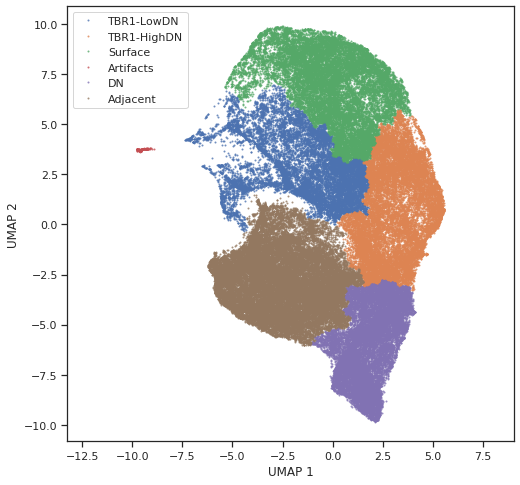

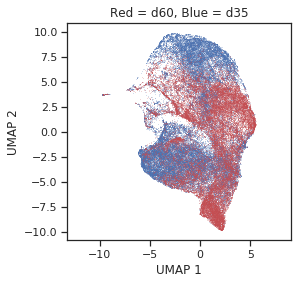

In [32]:
group1 = list(range(12))
group2 = list(range(12, 20))

plt.figure(figsize=(8, 8))
for i in range(0, class_labels.max() + 1):
    idx = np.where(labels == i)[0]
    plt.plot(x_umap[idx, 0], x_umap[idx, 1], '.', alpha=0.8, markersize=4, label=f'{cluster_names[i]}', markeredgewidth=0)
plt.ylim([-10, 10])
plt.axis('equal')
plt.legend()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig(os.path.join(working_dir, 'cyto_clusters_umap.pdf'), bbox_inches='tight')
plt.show()

# 10, 8, 7, 6 in purple cluster
    
plt.figure(figsize=(4, 4))
for i in np.unique(sample_labels):
    idx = np.where(sample_labels == i)[0]
#     plt.plot(x_umap[idx, 0], x_umap[idx, 1], '.', alpha=0.1, markersize=3, label=f'Sample {i}')
    if i in group2:
        plt.plot(x_umap[idx, 0], x_umap[idx, 1], 'r.', alpha=0.3, markersize=2, markeredgewidth=0)
    elif i in group1:
        plt.plot(x_umap[idx, 0], x_umap[idx, 1], 'b.', alpha=0.3, markersize=2, markeredgewidth=0)
plt.ylim([-10, 10])
plt.axis('equal')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Red = d60, Blue = d35')
plt.savefig(os.path.join(working_dir, 'cyto_d35_d60_umap.pdf'), bbox_inches='tight')
plt.show()

Inpsect profiles interactively

In [21]:
from sklearn.neighbors import NearestNeighbors
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

<IPython.core.display.Javascript object>


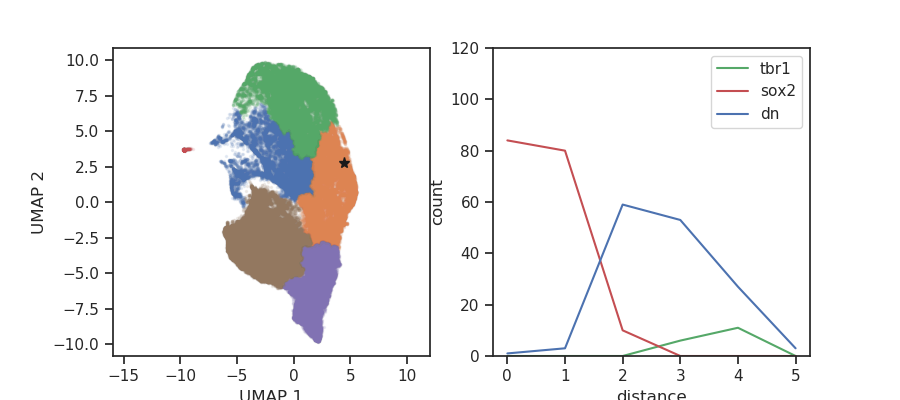

interactive(children=(FloatSlider(value=0.0, description='x', max=12.0, min=-16.0, step=0.05), FloatSlider(val…

In [22]:
%matplotlib notebook

x = -6
y = 4

min_val = -16
max_val = 12

embedding = x_umap

fig = plt.figure(figsize=(9, 4))

ax0 = plt.subplot(121)
for i in range(class_labels.max() + 1):
    idx = np.where(labels == i)[0]
    plt.plot(embedding[idx, 0], embedding[idx, 1], '.', markersize=3, alpha=0.1)
line, = plt.plot(x, y, 'k*', markersize=8)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xlim([min_val, max_val])

ax1 = plt.subplot(122)
ax1.set_ylim([0, 120])

nbrs = NearestNeighbors(1).fit(embedding)
dist, idx = nbrs.kneighbors(np.asarray([[x, y]]))
profile = profiles[idx][0, 0]

names = ['tbr1', 'sox2', 'dn']
colors = ['g', 'r', 'b']
line_profiles = []
for i, p in enumerate(profile):
    line_profile, = plt.plot(p, label=names[i], color=colors[i])
    line_profiles.append(line_profile)
plt.xlabel('distance')
plt.ylabel('count')
plt.legend(loc=1)
    
def update(x=0.0, y=0.0):
    line.set_xdata([x])
    line.set_ydata([y])
    
    _, idx = nbrs.kneighbors(np.asarray([[x, y]]))
    profile = profiles[idx][0, 0]
    for line_profile, p in zip(line_profiles, profile):
        line_profile.set_ydata(p)
    ax1.autoscale_view(None, False, True)
    fig.canvas.draw_idle()
    
interact(update, 
         x=widgets.FloatSlider(min=min_val, max=max_val, step=0.05),
         y=widgets.FloatSlider(min=min_val, max=max_val, step=0.05))

plt.show()

Show sample of profiles from each cluster

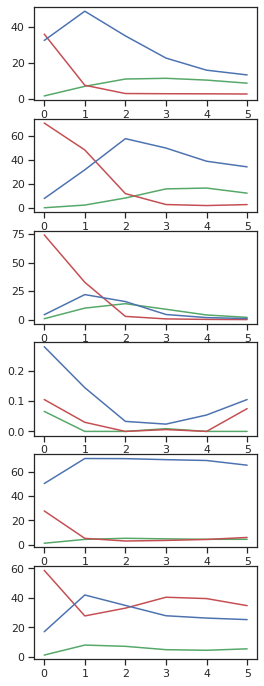

In [132]:
colors = ['g', 'r', 'b']
plt.figure(figsize=(4, 12))
for i in np.unique(class_labels):
    idx = np.where(labels == i)[0]
    profile_cluster = profiles[idx]
    average_profile = profile_cluster.mean(axis=0)
    
    plt.subplot(class_labels[-1] + 1, 1, i+1)
    for p, c in zip(average_profile, colors):
        plt.plot(p, color=c)
#     plt.axis('off')
plt.show()

<IPython.core.display.Javascript object>


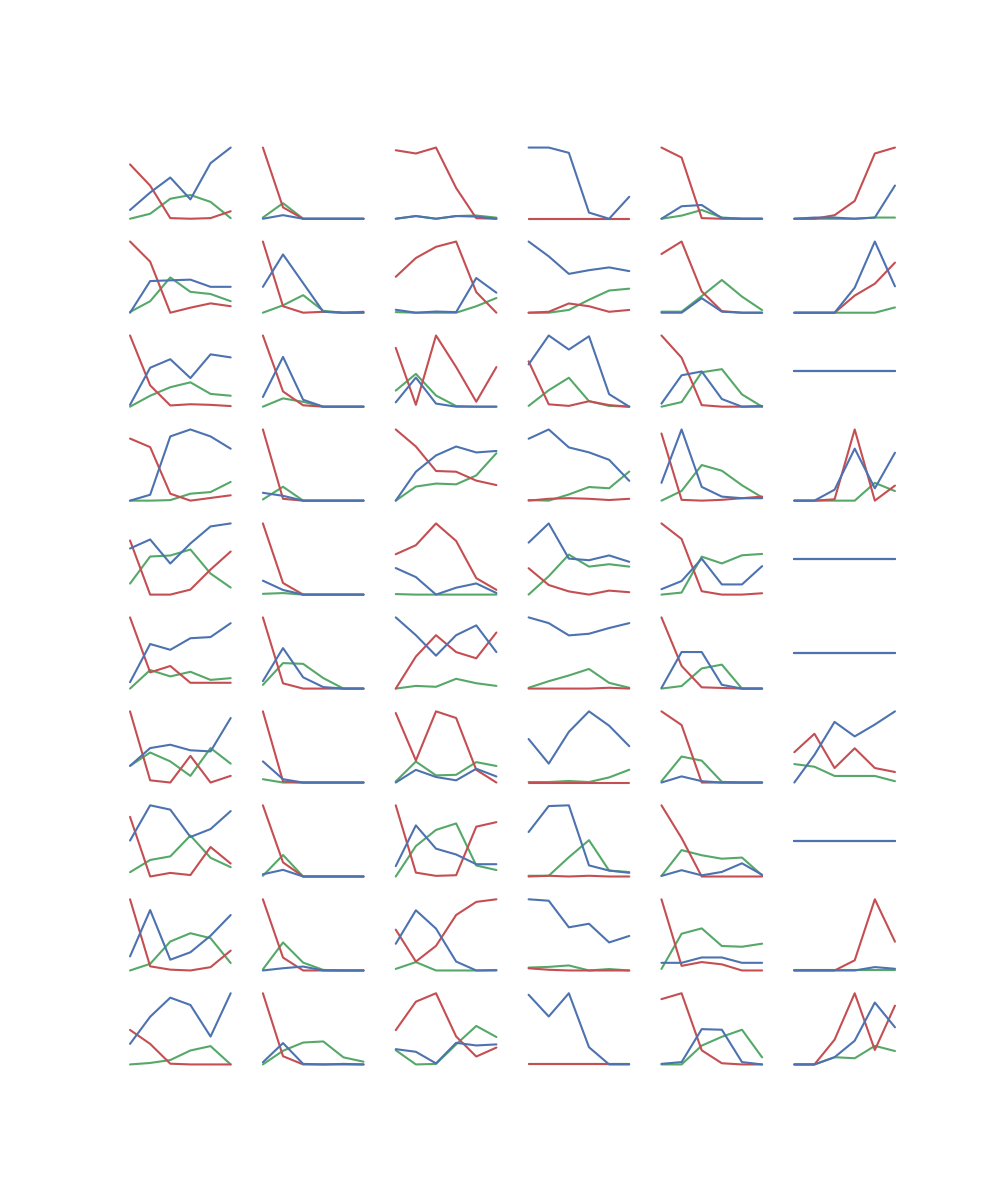

In [25]:
n_profiles = 10

plt.figure(figsize=(10, 12))
for i in np.unique(class_labels):
    idx = np.where(labels == i)[0]
    profile_cluster = profiles[idx]
    
    np.random.shuffle(profile_cluster)
    sample = profile_cluster[:n_profiles]
    
    for j, s in enumerate(sample):
        subplot_idx = len(class_labels) * j + i + 1
        plt.subplot(n_profiles, class_labels[-1] + 1, subplot_idx)
        for p, c in zip(s, colors):
            plt.plot(p, color=c)
            plt.axis('off')
plt.show()

- Euclidean distance metric, 6 clusters on UMAP looks good
- Correlation distance metric, 5 clusters may look better

Build Seaborn Lineplots

In [131]:
import pandas as pd
import seaborn as sns

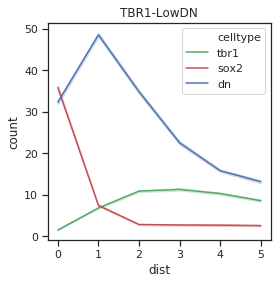

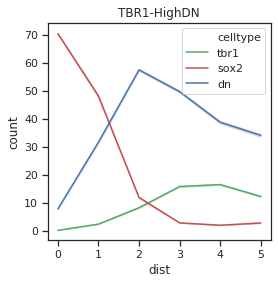

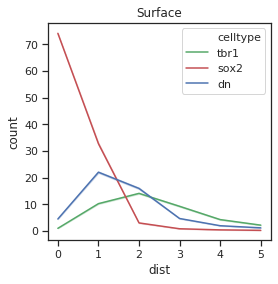

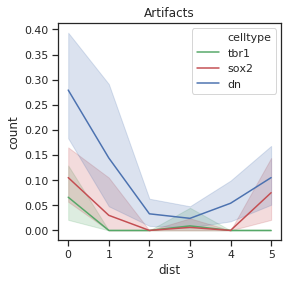

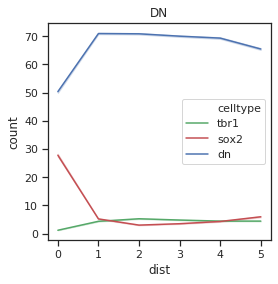

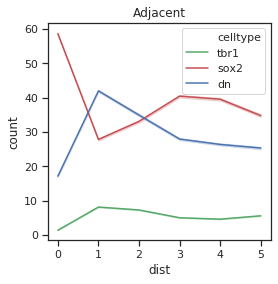

In [133]:
%matplotlib inline

cluster_names = ['TBR1-LowDN',
                 'TBR1-HighDN',
                 'Surface',
                 'Artifacts',
                 'DN',
                 'Adjacent']

celltype_names = ['tbr1', 'sox2', 'dn']

for cluster_to_plot in range(len(cluster_names)):
    
    dist = []
    count = []
    celltype = []
    cluster = []
    
    for i, profile in enumerate(profiles):
        for k, p in enumerate(profile):
            for b, c in enumerate(p):
                cluster_name = cluster_names[labels[i]]
                if cluster_name == cluster_names[cluster_to_plot]:
                    dist.append(b)
                    count.append(c)
                    cluster.append(cluster_name)
                    celltype.append(celltype_names[k])
                    
    df = pd.DataFrame({'dist': dist, 
                       'count': count, 
                       'celltype': celltype})
    
    # Plot this cluster average profile
    plt.figure(figsize=(4, 4))
    sns.lineplot(x="dist", y="count",
             hue="celltype", ci=99, palette=['g', 'r', 'b'],
             data=df)
    plt.title(cluster_names[cluster_to_plot])
    plt.savefig(os.path.join(working_dir, f'average_profile_{cluster_names[cluster_to_plot]}.pdf'),
                bbox_inches='tight')
    plt.show()

Save the cluster labels

In [28]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5])

In [34]:
np.save(os.path.join(working_dir, 'cyto_labels_combined.npy'), labels)

Save the UMAP embedding

In [10]:
import joblib

filename = 'model_d35_d60.umap'
joblib.dump(model, os.path.join(working_dir, filename))

['/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/model_d35_d60.umap']

Extract ROIs around cluster exemplar vertices

In [36]:
from scout import io
from scout.cyto import load_mesh
from scout.utils import read_voxel_size, extract_box

In [44]:
d35_folders = list(filter(lambda x: x.startswith('2019'), os.listdir(os.path.join(working_dir, 'Lancaster_d35'))))
d35_folders.sort()
d60_folders = list(filter(lambda x: x.startswith('2019'), os.listdir(os.path.join(working_dir, 'Lancaster_d60'))))
d60_folders.sort()
d35_dirs = [os.path.join(working_dir, 'Lancaster_d35', f, 'dataset') for f in d35_folders]
d60_dirs = [os.path.join(working_dir, 'Lancaster_d60', f, 'dataset') for f in d60_folders]
org_dirs = d35_dirs + d60_dirs
org_dirs

['/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190419_14_35_07_AA_org1_488LP13_561LP120_642LP60/dataset',
 '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190419_15_50_16_AA_org2_488LP13_561LP120_642LP60/dataset',
 '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190419_16_09_03_AA_org3_488LP13_561LP120_642LP60/dataset',
 '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190430_11_36_09_AA-4.30.19-org1_488LP12p5_561LP120_642LP50/dataset',
 '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190430_15_06_10_AA-4.30.19-org3_488LP13_561LP120_642LP50/dataset',
 '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190614_14_03_07_AA_ef23-1_488LP14_561LP120_642LP60/dataset',
 '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190614_14_48_43_AA_ef23-2_488LP14_561LP120_642LP50/dataset',
 '/data/datasets/organoid_phenotyping/analysis/

In [45]:
cluster_idxs = [np.where(labels == lbl)[0] for lbl in np.unique(labels)]
cluster_centroids = np.asarray([x_umap[idx].mean(axis=0) for idx in cluster_idxs])
cluster_centroids

array([[-1.5632136 ,  2.8317783 ],
       [ 3.1192374 ,  0.7448555 ],
       [-0.04403977,  6.88734   ],
       [-9.635316  ,  3.7269592 ],
       [ 1.7986493 , -5.998585  ],
       [-2.5347457 , -2.7595227 ]], dtype=float32)

In [127]:
_, idx = nbrs.kneighbors(cluster_centroids, n_neighbors=10)
neighbor_idx = np.array([7, 2, 0, 4, 5, 1])
example_idx = idx[np.arange(len(cluster_centroids)), neighbor_idx]
example_idx

array([95433, 93154,   994, 24820,  1658, 58988])

In [128]:
org_idxs = sample_labels[example_idx]
example_dirs = [org_dirs[p] for p in org_idxs]
example_dirs

['/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d60/20190531_20_32_55_AA_fatty7_488LP13_561LP140_642LP50/dataset',
 '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d60/20190531_18_54_48_AA_fatty6_488LP14_561LP100_642LP50/dataset',
 '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190419_14_35_07_AA_org1_488LP13_561LP120_642LP60/dataset',
 '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190430_15_06_10_AA-4.30.19-org3_488LP13_561LP120_642LP50/dataset',
 '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190419_14_35_07_AA_org1_488LP13_561LP120_642LP60/dataset',
 '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190614_18_27_34_AA_ef23-7_488LP14_561LP120_642LP50/dataset']

ROI center: [ 708 2735 4302]
[0.24913739 0.96205944 0.11123038]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


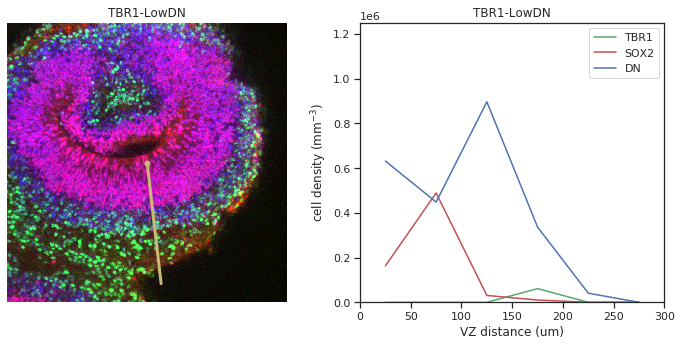

ROI center: [ 171 3707 3301]
[ 0.09015515 -0.34556314 -0.9340547 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


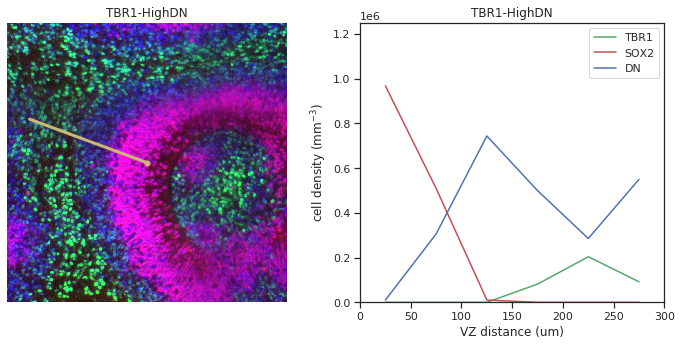

ROI center: [ 649 1440 1349]
[-0.4020595 -0.6325692 -0.6619701]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


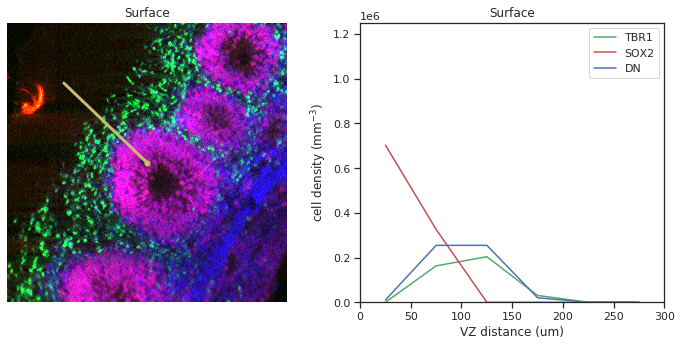

ROI center: [ 600 1759 3060]
[-0.88110405  0.46840462 -0.06521316]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


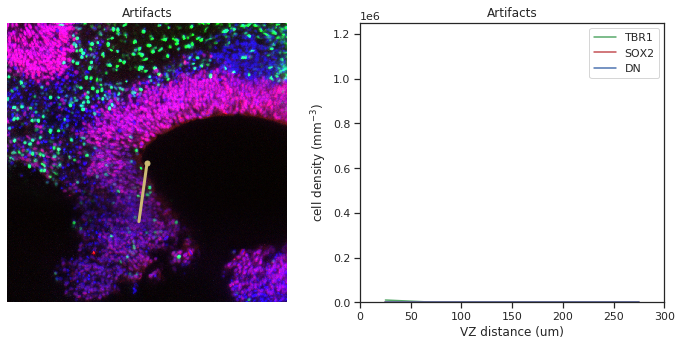

ROI center: [ 840 1290 1583]
[-0.1547553   0.88179404 -0.44552222]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


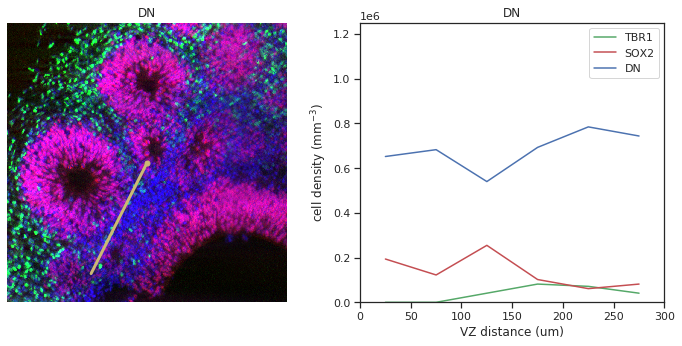

ROI center: [ 318 1619 2190]
[-0.00273269  0.8807454   0.47358212]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


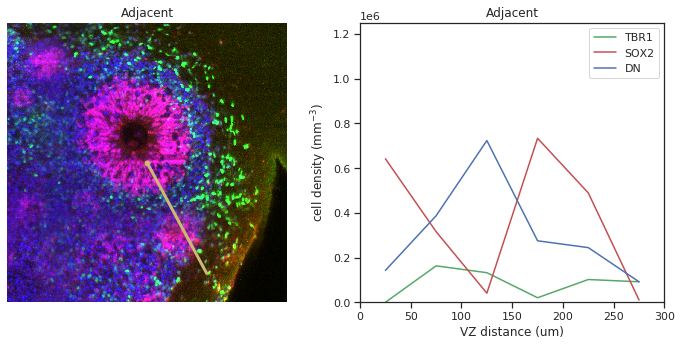

In [129]:
width = 1024
# depth = 1

org_dir = example_dirs[0]

for k, org_dir in enumerate(example_dirs):
    # Get the ROI center coordinates
    combined_sample_idx = np.where(sample_labels == org_idxs[k])[0]
    example_sample_idx = np.where(combined_sample_idx == example_idx[k])[0]
    cyto_sample_idx = np.load(os.path.join(org_dir, 'cyto_sample_index.npy'))
    example_vertex_idx = cyto_sample_idx[example_sample_idx][0]
    mesh = load_mesh(os.path.join(org_dir, 'mesh_ventricles.pkl'))
    normal = mesh['normals'][example_vertex_idx]
    example_vertex_um = mesh['verts'][example_vertex_idx]
    voxel_size = np.asarray(read_voxel_size(os.path.join(org_dir, 'voxel_size.csv')))
    example_coord = (example_vertex_um / voxel_size).astype(np.int)
    print(f'ROI center: {example_coord}')
    print(normal)

    # Extract ROI
    syto = io.open(os.path.join(org_dir, 'syto.zarr'))
    sox2 = io.open(os.path.join(org_dir, 'sox2.zarr'))
    tbr1 = io.open(os.path.join(org_dir, 'tbr1.zarr'))
    start = np.array([example_coord[0], example_coord[1] - width // 2, example_coord[2] - width // 2])
    stop = np.array([example_coord[0] + 1, example_coord[1] + width // 2, example_coord[2] + width // 2])
    syto_roi = extract_box(syto, start, stop)[0]
    sox2_roi = extract_box(sox2, start, stop)[0]
    tbr1_roi = extract_box(tbr1, start, stop)[0]
    
    # Get Profile for normal
    example_profile = profiles[example_idx[k]]
    syto_profile = example_profile

    # Plot the ROIs
    plt.figure(figsize=(12, 36))
    
    plt.subplot(len(example_dirs), 2, 2*k+1)
    plt.imshow(np.dstack([sox2_roi / max(np.percentile(sox2_roi, 99), 0.02), 
                          tbr1_roi / max(np.percentile(tbr1_roi, 99), 0.02), 
                          syto_roi / max(np.percentile(syto_roi, 99), 0.02)]))
    plt.plot([width // 2, normal[2] * 300/voxel_size[2] + width // 2], 
             [width // 2, normal[1] * 300/voxel_size[1] + width // 2], 
             'y-', linewidth=3)
    plt.plot([width // 2], [width // 2], 'y.', markersize=10)
    plt.axis('off')
    plt.title(f'{cluster_names[k]}')
    
    plt.subplot(len(example_dirs), 2, 2*k+2)
    example_profile = profiles[example_idx[k]]
    bin_volume = (50/1000) * (np.pi * (25/1000)**2)  # mm3
    x = np.arange(25, 325, 50)
    plt.plot(x, example_profile[0] / bin_volume, 'g-', label='TBR1')
    plt.plot(x, example_profile[1] / bin_volume, 'r-', label='SOX2')
    plt.plot(x, example_profile[2] / bin_volume, 'b-', label='DN')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.title(f'{cluster_names[k]}')
    plt.xlabel('VZ distance (um)')
    plt.ylabel('cell density (mm$^{-3}$)')
    plt.xlim([0, 300])
    plt.ylim([0, 1_250_000])
    plt.legend()
    
    plt.savefig(os.path.join(working_dir, f'example_roi_{cluster_names[k]}.pdf'), bbox_inches='tight')
    plt.show()